<a href="https://colab.research.google.com/github/vggls/M.Sc._AI_Thesis/blob/main/experiments/xrays_resnet34/VGG19_training_%26_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import plotly.graph_objects as go
import cv2
import os
import shutil
import copy
import pickle

In [ ]:
from torchvision import transforms, datasets, models
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
# custom written code
from xrays import create_datasets, summaries
from training_loop import Train
from train_model import fit
from imbalanced import class_weights
from vgg19 import VGG19
#from resnet import ResNet
from testing_report import Test_Report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Download from Kaggle**


In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download tawsifurrahman/covid19-radiography-database

 98% 762M/778M [00:04<00:00, 177MB/s]
100% 778M/778M [00:04<00:00, 185MB/s]


In [ ]:
! unzip covid19-radiography-database.zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png

# **3.A first look at the data: Class distribution**

In [ ]:
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
dataset_path = '/content/COVID-19_Radiography_Dataset'

points = []
total = 0

for clas in classes:
    class_path = os.path.join(dataset_path, clas, 'images')
    class_images = os.listdir(class_path)
    points.append(len(class_images))
    total += len(class_images)

fig = go.Figure()
for i, clas in enumerate(classes):
    percent = round(points[i] / total * 100, 2)
    text = f"{points[i]} ({percent}%)"
    fig.add_trace(go.Bar(x=[clas], y=[points[i]], text=[text], textposition='outside', showlegend=False, marker=dict(color="steelblue")))

fig.update_layout(width=650, height=550, title='Covid-19 Radiography Dataset: Class distribution', title_x=0.5)
fig.show()

# **4. Training, Validation and Test Datasets**

In [ ]:
#shutil.rmtree('/content/COVID-19_Radiography_Dataset/training_dataset')
#shutil.rmtree('/content/COVID-19_Radiography_Dataset/validation_dataset')
#shutil.rmtree('/content/COVID-19_Radiography_Dataset/test_dataset')

In [ ]:
# to be applied to training data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          #recommended size
    transforms.RandomHorizontalFlip(),      #data augmentation
    transforms.RandomVerticalFlip(),        #data augmentation
    transforms.RandomRotation(degrees=20),  #data augmentation
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])
# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
train_dataset, validation_dataset, test_dataset = create_datasets(train_transforms, test_transforms)

In [ ]:
labels = train_dataset.class_to_idx
summaries(labels, bar_plot=True)

# **5. Dataset Visualization**

<Figure size 432x288 with 0 Axes>

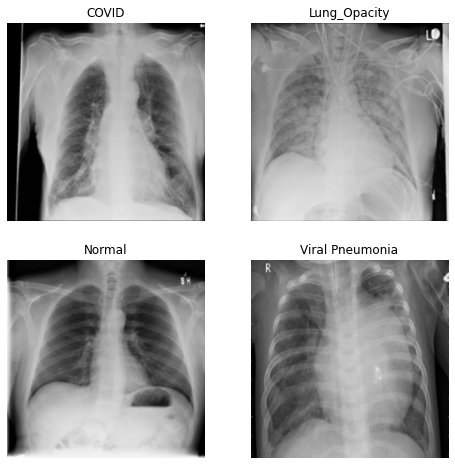

In [ ]:
dataset_path = '/content/COVID-19_Radiography_Dataset'

indices = [(0,0), (0,1), (1,0), (1,1)]

plt.figure()

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

for i, clas in zip(indices, classes):
    class_path = os.path.join(dataset_path, clas, 'images')
    class_image = os.listdir(class_path)[1000]
    img_path = os.path.join(class_path, class_image)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(clas)
    ax[i].axis('off')

plt.show()

# **7. VGG19**

In [ ]:
weights = class_weights('./COVID-19_Radiography_Dataset/training_dataset', train_dataset)

COVID class - instances 2892 - assigned weight 0.00034578146611341634
Lung_Opacity class - instances 4809 - assigned weight 0.0002079434393844874
Normal class - instances 8153 - assigned weight 0.00012265423770391266
Viral Pneumonia class - instances 1076 - assigned weight 0.0009293680297397769


In [ ]:
vgg19 = VGG19(num_classes = 4, trainable_feature_layers = [i for i in range(21,35)])

>**training**

In [ ]:
loss_fct = torch.nn.CrossEntropyLoss(weights.cuda())
optimizer = optim.Adam(vgg19.model.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

training_dict, validation_dict = fit(train_dataset=train_dataset,
                                     validation_dataset=validation_dataset,
                                     batch_size=128,
                                     model=vgg19,
                                     loss_fct=loss_fct,
                                     optimizer=optimizer,
                                     scheduler=None,
                                     epochs=100,
                                     patience=20,
                                     no_of_classes=4,
                                     labels_of_normal_classes=[2])

Device: cuda:0
Starting training..
-----------------------------------
Epoch 1/100
->Training phase
  Loss=0.8518
  Accuracy=0.67 - Recall per class=[0.64, 0.64, 0.68, 0.91]
->Validation phase
  Loss=0.3581
  Accuracy=0.86 - Recall per class=[0.79, 0.79, 0.92, 0.99]
->New model saved!
-----------------------------------
Epoch 2/100
->Training phase
  Loss=0.3386
  Accuracy=0.85 - Recall per class=[0.85, 0.84, 0.84, 0.96]
->Validation phase
  Loss=0.4744
  Accuracy=0.85 - Recall per class=[0.5, 0.89, 0.94, 0.99]
-----------------------------------
Epoch 3/100
->Training phase
  Loss=0.2659
  Accuracy=0.88 - Recall per class=[0.9, 0.86, 0.87, 0.97]
->Validation phase
  Loss=0.2335
  Accuracy=0.9 - Recall per class=[0.9, 0.91, 0.89, 0.99]
->New model saved!
-----------------------------------
Epoch 4/100
->Training phase
  Loss=0.2236
  Accuracy=0.9 - Recall per class=[0.93, 0.89, 0.89, 0.97]
->Validation phase
  Loss=0.1990
  Accuracy=0.91 - Recall per class=[0.93, 0.89, 0.91, 0.99]
->Ne

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training complete !


In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/Covid-19_Radiography_Dataset/Models/'
with open(drive_path + 'xrays_vgg19_training_dict.pickle', 'wb') as f:
  pickle.dump(training_dict, f)
with open(drive_path + 'xrays_vgg19_validation_dict.pickle', 'wb') as f:
  pickle.dump(validation_dict, f)

>**loss history plot**

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(training_dict['loss'])+1 )), y=training_dict['loss'], name='Training'))
fig.add_trace(go.Scatter(x=list(range(1, len(validation_dict['loss'])+1 )), y=validation_dict['loss'], name='Validation'))
fig.update_layout(title='VGG19 Loss history (Optimal model at epoch 21)',
                  title_x=0.5,
                   xaxis_title='Epochs',
                   yaxis_title='Loss',
                  height=400, width=800,)
fig.show()

>**testing**

In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/Covid-19_Radiography_Dataset/Models/'

vgg19 = torch.load(drive_path + 'xrays_vgg19.pt')

test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
classes = [ 'COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
test_report = Test_Report(test_loader, vgg19, classes)

Device: cuda:0


In [ ]:
print('\033[1m' + 'Model: xrays_vgg19.pt' + '\033[0m \n')
test_report.classification_report()
bal_acc=test_report.balanced_accuracy()
print(f'Balanced Accuracy Score: {round(bal_acc, 2)}')

Model: xrays_vgg19.pt 

                 precision    recall  f1-score   support

          COVID       0.94      0.97      0.95       362
   Lung_Opacity       0.89      0.93      0.91       602
         Normal       0.96      0.92      0.94      1020
Viral Pneumonia       0.92      0.98      0.95       135

       accuracy                           0.93      2119
      macro avg       0.93      0.95      0.94      2119
   weighted avg       0.93      0.93      0.93      2119

Balanced Accuracy Score: 0.95


In [ ]:
print('\033[1m' + 'Model: xrays_vgg19.pt' + '\033[0m')
scores = test_report.roc_curve_and_scores(plot=True)
print(f'Mean AUC score: {round(sum(scores)/len(scores),3)}')
_ = test_report.pr_curve_and_scores(plot=True)

Model: xrays_vgg19.pt


Mean AUC score: 0.992
